# Filter visualizer tutorial
#### The filter visualizer offers a powerful tool for observing and debugging neural network weights. The PCA representation is available for each neuron in the chosen convolutional neural network layer (if the dimensionality of the weight is 3 or less then the PCA is not done) and you can explore both the Fourier transform and the 3D representation of each neuron channel

We will see how to use the filter visualizer in this tutorial. Lets first import some libraries

In [1]:
import numpy as np
import threading
from utils import plot_in_3D
from IPython.display import IFrame, display
from filter_visualizer import app
from PIL import Image
import torch
import torch.nn.functional as F

Using cache found in C:\Users\Marcos/.cache\torch\hub\pytorch_vision_v0.10.0


Next, lets launch our filter visualizer application. This application has been developed using Flask, a Python web development framework. We will run it in a thread in order to be able to use it within a notebook

In [2]:
def run():
    app.run(port=5000, use_reloader=False)

threading.Thread(target=run).start()

 * Serving Flask app 'filter_visualizer' (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)


Now lets open the web app, if you use the default settings you should go to your web browser and open the following webpage http://localhost:5000/. Hopefully you are able to see the filter visualizer now. As you can see, the following features are available:
* Layer dropdown to select the convolutional layer of the chosen neural network.
* Weight dropdown for choosing specific neurons within a layer.
* Feature map range buttons that allow the visualization of specific channels within a neuron.
* 2D neuron visualization, using PCA for neurons that exceed three channels, in order to visualize the neuron in RGB.
* Fourier space visualization for each neuron channel.
* 3D plotting of individual channels within the selected neuron.

Notice that indexes start with 0

In [3]:
IFrame('http://localhost:5000/', width=1800, height=800)


But what can we do with the filter visualizer? Well... lets take for instance the first neuron of the first convolutional layer

In [4]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet', weights='AlexNet_Weights.DEFAULT')
model.eval()

conv_layer = model.features[0]
with torch.no_grad():
    weight = conv_layer.weight[0, :, :, :].cpu().numpy().transpose(1, 2, 0)

Using cache found in C:\Users\Marcos/.cache\torch\hub\pytorch_vision_v0.10.0


Lets display the weight as it is done in the filter visualizer. Observe that there is difference between the left and right sides of the neuron

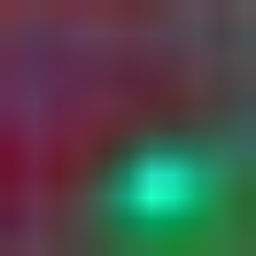

In [5]:
weight_pil = 255.0 * (weight - np.min(weight)) / (np.max(weight) - np.min(weight))
weight_pil = Image.fromarray(np.uint8((weight_pil)))
weight_pil = weight_pil.resize((256, 256), Image.BILINEAR)
display(weight_pil)

We will also generate a stimulus to better understand how the neuron responds to specific image inputs

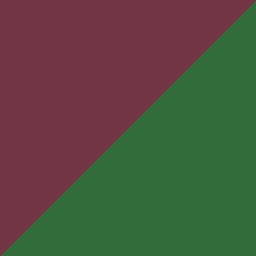

In [6]:
color_1 = weight_pil.getpixel((0, 0))
color_2 = weight_pil.getpixel((255, 255))

color_1_r, color_1_g, color_1_b = color_1[0], color_1[1], color_1[2]
color_2_r, color_2_g, color_2_b = color_2[0], color_2[1], color_2[2]

width, height = 256, 256

image_np = np.zeros((height, width, 3), dtype=np.uint8)

mask = np.arange(width) + np.arange(height)[:, np.newaxis] >= width

image_np[:, :, 0] = np.where(mask, color_2_r, color_1_r)   # Red channel
image_np[:, :, 1] = np.where(mask, color_2_g, color_1_g)   # Green channel
image_np[:, :, 2] = np.where(mask, color_2_b, color_1_b)   # Blue channel

img = Image.fromarray(image_np)

display(img)

Now, lets convolve our stimulus with this neuron

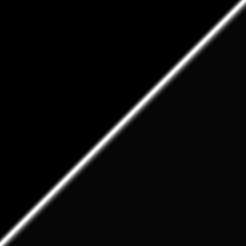

127.0.0.1 - - [10/Sep/2023 21:50:41] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [10/Sep/2023 21:50:41] "GET /static/css/styles.css HTTP/1.1" 304 -
127.0.0.1 - - [10/Sep/2023 21:50:41] "GET /static/js/scripts.js HTTP/1.1" 304 -
127.0.0.1 - - [10/Sep/2023 21:50:41] "GET /num_channels?layer_index=0 HTTP/1.1" 200 -
127.0.0.1 - - [10/Sep/2023 21:50:42] "GET /layer_indexes HTTP/1.1" 200 -
127.0.0.1 - - [10/Sep/2023 21:50:42] "GET /weights?index=0&layer_index=0&fil_num_start=0 HTTP/1.1" 200 -
127.0.0.1 - - [10/Sep/2023 21:50:42] "GET /weights_gray?index=0&layer_index=0&t=1694375442167 HTTP/1.1" 200 -
127.0.0.1 - - [10/Sep/2023 21:50:42] "GET /weights_fft?index=0&layer_index=0 HTTP/1.1" 200 -


In [7]:
image_tensor = torch.tensor(image_np).unsqueeze(0).permute(0, 3, 1, 2).float()
weight_tensor = torch.tensor(weight).unsqueeze(0).permute(0, 3, 1, 2).float()

convolved_tensor = F.conv2d(image_tensor, weight_tensor)

convolved_image_np = convolved_tensor.squeeze(0).permute(1, 2, 0).numpy()

convolved_image_np = (convolved_image_np - convolved_image_np.min()) / (convolved_image_np.max() - convolved_image_np.min()) * 255
convolved_image_np = convolved_image_np.astype(np.uint8)

convolved_image_np = np.squeeze(convolved_image_np)

img = Image.fromarray(convolved_image_np)
display(img)

From our analysis, it is evident that we are able to use this neuron to identify transitions between red and green colors within an image